<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L32-GraphAttentionNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks

## Introducing the graph attention layer
The main idea behind GATs is that some nodes are more important than others. In fact, this was already the case with the graph convolutional layer: nodes with few neighbors were more important than others, thanks to the normalization coefficient:

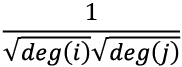

This approach is limiting because it only takes into account node degrees. On the other hand, the goal of the graph attention layer is to produce weighting factors that also consider the importance of node features.

Let’s call our weighting factors attention scores and note, $\alpha_{ij}$, the attention score between the nodes $i$ and $j$. We can define the graph attention operator as follows:

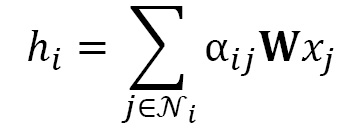

An important characteristic of GATs is that the attention scores are calculated implicitly by comparing inputs to each other (hence the name self-attention). In this section, we will see how to calculate these attention scores in four steps and also how to make an improvement to the graph attention layer:

- Linear transformation
- Activation function
- Softmax normalization
- Multi-head attention
-  Improved graph attention layer

First things first, let’s see how the linear transformation differs from previous architectures.

### Linear transformation

The attention score represents the importance between a central node $i$ and a neighbor $j$. As stated previously, it requires node features from both nodes. In the graph attention layer, it is represented by a concatenation between the hidden vectors $Wx_i$ and $Wx_j$, $\[Wx_i||$Wx_j]$$. Here, $W$ is a classic shared weight matrix to compute hidden vectors. An additional linear transformation is applied to this result with a dedicated learnable weight matrix $w_{att}$. During training, this matrix learns weights to produce attention coefficients $a_{ij}$. This process is summarized by the following formula:

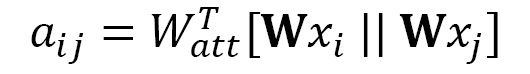

This output is given to an activation function like in traditional neural networks.

### Activation function
Nonlinearity is an essential component in neural networks to approximate nonlinear target functions. Such functions could not be captured by simply stacking linear layers, as their final outcome would still behave like a single linear layer.

In the official implementation (https://github.com/PetarV-/GAT/blob/master/utils/layers.py), the authors chose the Leaky Rectified Linear Unit (ReLU) activation function. This function fixes the dying ReLU problem, where ReLU neurons only output zero:

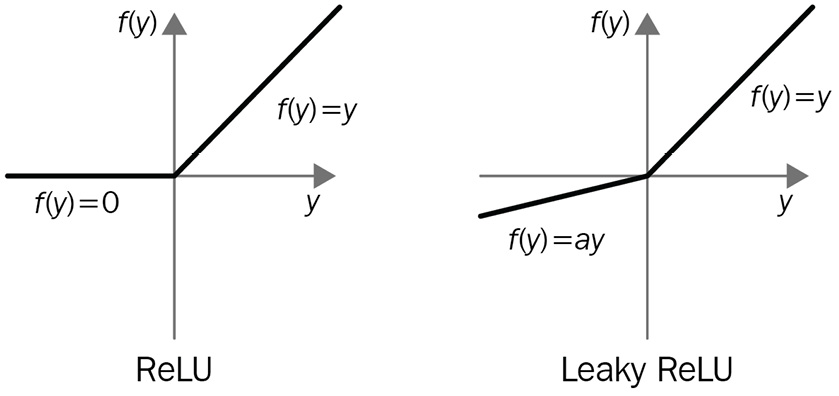

This is implemented by applying the Leaky ReLU function to the output of the previous step:

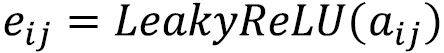

However, we are now facing a new problem: the resulting values are not normalized!

### Softmax normalization

We want to compare different attention scores, which means we need normalized values on the same scale. In machine learning, it is common to use the softmax function for this purpose. Let’s call $𝞜_i$ the neighboring nodes of node $i$, including itself:

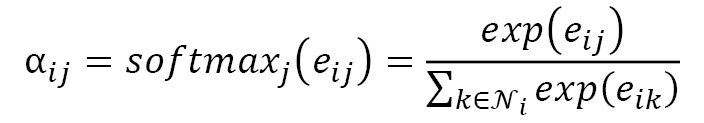

The result of this operation gives us our final attention scores $\alpha_{ij}$. But there’s another problem: self-attention is not very stable.

### Multi-head attention
This issue was already noticed by Vaswani et al. (2017) in the original transformer paper. Their proposed solution consists of calculating multiple embeddings with their own attention scores instead of a single one. This technique is called multi-head attention.

The implementation is straightforward, as we just have to repeat the three previous steps multiple times. Each instance produces an embedding $h_i^k$, where $k$ is the index of the attention head. There are two ways of combining these results:

- **Averaging**: With this, we sum the different embeddings and normalize the result by the number of attention heads $N$:

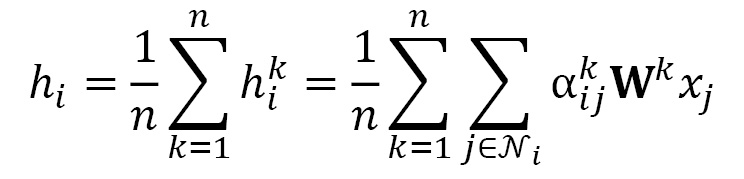

- **Concatenation**: Here, we concatenate the different embeddings, which will produce a larger matrix:

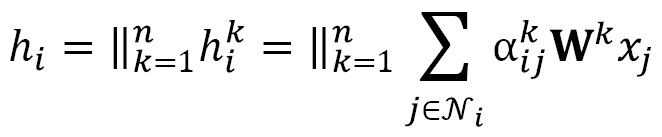

In practice, there is a simple rule to know which one to use: we choose the concatenation scheme when it’s a hidden layer and the average scheme when it’s the last layer of the network. The entire process can be summarized by the following diagram:

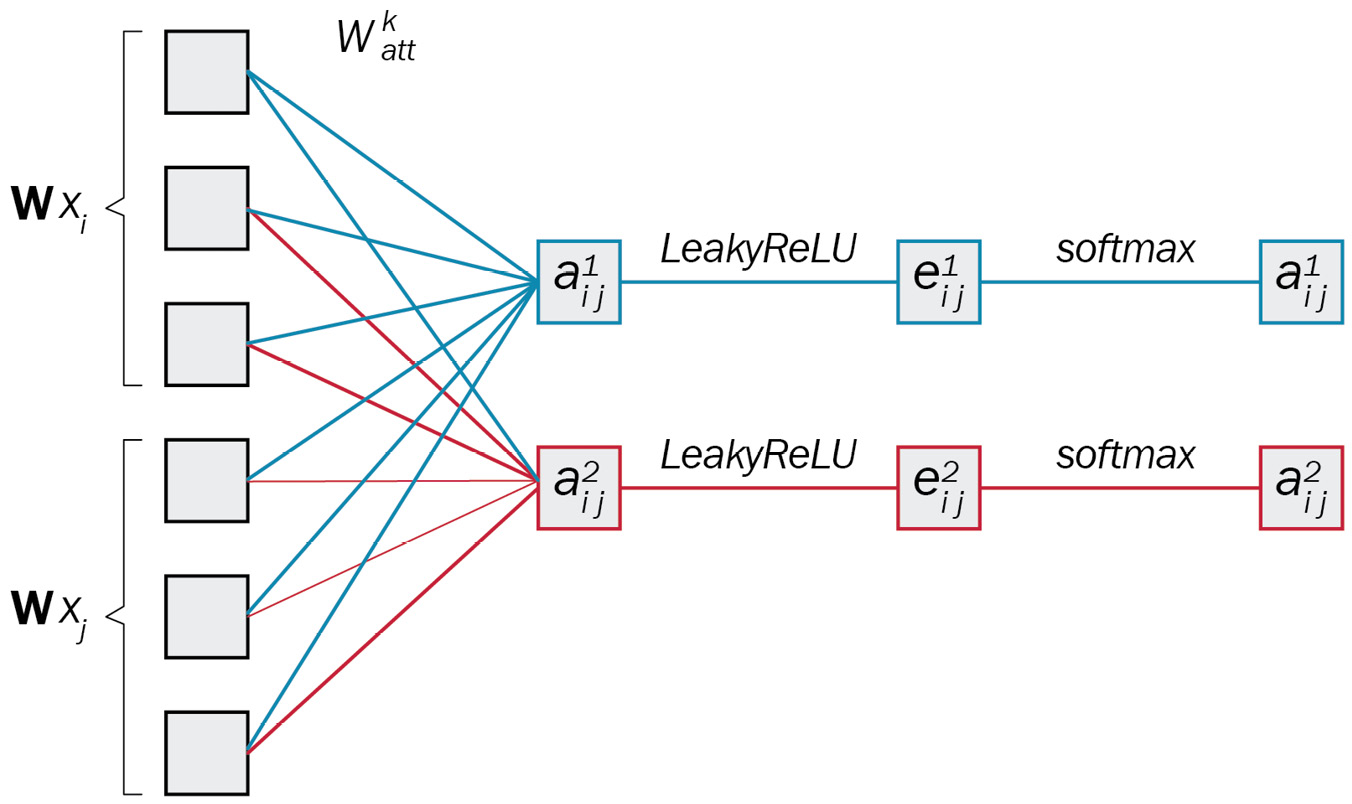

This is all there is to know about the theoretical aspect of the graph attention layer. However, since its inception in 2017, an improvement has been suggested.

### Improved graph attention layer

Brody et al. (2021) argued that the graph attention layer only computes a static type of attention. This is an issue because there are simple graph problems we cannot express with a GAT. So they introduced an improved version, called GATv2, which computes a strictly more expressive dynamic attention.

Their solution consists of modifying the order of operations. The weight matrix $W$ is applied after the concatenation and the attention weight matrix $W_{att}$ after the $LeakyReLU$ function. In summary, here is the original **Graph Attentional Operator**, also GAT:

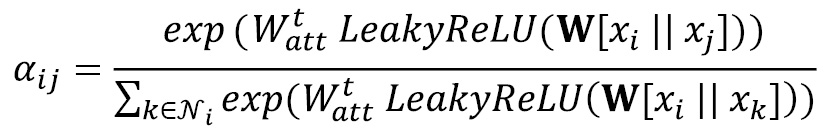

And this is the modified operator, GATv2:

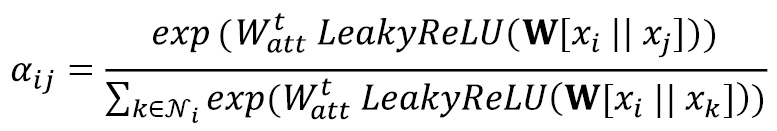

Which one should we use? According to Brody et al., GATv2 consistently outperforms the GAT and thus should be preferred. In addition to the theoretical proof, they also ran several experiments to show the performance of GATv2 compared to the original GAT. In the rest of this chapter, we will consider both options: the GAT in the second section and GATv2 in the third section.


### Implementing the graph attention layer in NumPy

As previously stated, neural networks work in terms of matrix multiplications. Therefore, we need to translate our individual embeddings into operations for the entire graph. In this section, we will implement the original graph attention layer from scratch to properly understand the inner workings of self-attention. Naturally, this process can be repeated several times to create multi-head attention.

The first step consists of translating the original graph attention operator in terms of matrices. This is how we defined it in the last notebook:

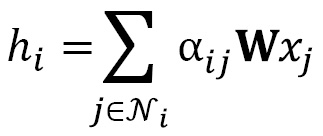

By taking inspiration from the graph linear layer, we can write the following:

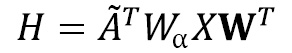

Where $Wα$ is a matrix that stores every $α_{ij}$. In this example, we will use the following graph:

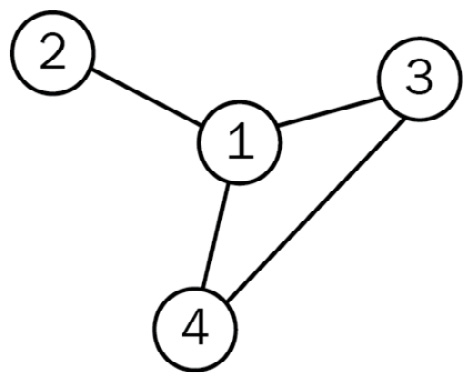

The graph must provide two important pieces of information:

1. the adjacency matrix with self-loops $\tilde{A}$
2. the node features $X$.

Let’s see how to implement it in NumPy

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 117.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


We can build the adjacency matrix from the connections

In [2]:
import numpy as np
np.random.seed(0)

A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
A

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

For $X$, we generate a random matrix of node features using `np.random.uniform()`:

In [3]:
X = np.random.uniform(-1, 1, (4, 4))
X

array([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823, -0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ]])

The next step is to define our weight matrices. Indeed, in graph attention layers, there are two of them: the regular weight matrix $W$, and the attention weight matrix $W_{att}$. There are different ways to initialize them (Xavier or He initialization, for example), but we can just reuse the same random function in this example.

The matrix $W$ has to be carefully designed as its dimensions are  

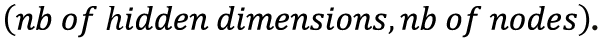

Notice that **nb of noes = 4** is already fixed because it represents the number of nodes in $X$. On the contrary, the value of **nb of hidden dimensions** is arbitrary: we’ll choose  in this example:

In [4]:
W = np.random.uniform(-1, 1, (2, 4))
W

array([[-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835]])

This attention matrix is applied to the concatenation of hidden vectors to produce a unique value. Thus, its size needs to be:

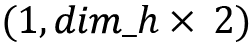

In [5]:
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[-0.76345115,  0.27984204, -0.71329343,  0.88933783]])

We want to concatenate hidden vectors from source and destination nodes. A simple way to obtain pairs of source and destination nodes is to look at our adjacency matrix $\hat{A}$ in COO format: rows store source nodes, and columns store destination nodes. NumPy provides a quick and efficient way of doing it with `np.where()`

In [6]:
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

We can concatenate hidden vectors of source and destination nodes using `np.concatenate`:

In [7]:
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1)

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

We then apply a linear transformation to this result with the attention matrix $W_{att}$

In [8]:
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1).T
a

array([[-0.1007035 , -0.35942847,  0.96036209,  0.50390318, -0.43956122,
        -0.69828618,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])


The second step consists of applying a Leaky ReLU function to the previous outcome:

In [9]:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318, -0.08791224,
        -0.13965724,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

We have the right values but need to place them correctly in a matrix. This matrix should look like $\hat{A}$ because there is no need for unnormalized attention scores when there is no connection between two nodes. To build this matrix, we know the sources $i$ and destinations $j$ thanks to `connections`. So, the first value in **e** corresponds to $e_{00}$, the second value to $e_{01}$, but the seventh value corresponds to $e_{20}$ and not to $e_{12}$. We can fill the matrix as follows:

In [10]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318],
       [-0.08791224, -0.13965724,  0.        ,  0.        ],
       [ 0.79964181,  0.        ,  1.8607074 ,  1.40424849],
       [ 0.64260322,  0.        ,  1.70366881,  1.2472099 ]])

The next step is to normalize every row of attention scores. This requires a custom softmax function to produce our final attention scores:

In [11]:
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
W_alpha

array([[0.15862414, 0.15062488, 0.42285965, 0.26789133],
       [0.24193418, 0.22973368, 0.26416607, 0.26416607],
       [0.16208847, 0.07285714, 0.46834625, 0.29670814],
       [0.16010498, 0.08420266, 0.46261506, 0.2930773 ]])

This attention matrix $W_{\alpha}$ provides weights for every possible connection in the network. We can use it to calculate our matrix of embeddings $H$, which should give us two-dimensional vectors for each node:

In [12]:
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.10126376,  1.99749693],
       [-0.33950544,  0.97045933],
       [-1.03570438,  1.53614075],
       [-1.03570438,  1.53614075]])

Our graph attention layer is now complete! Adding multi-head attention consists of repeating these steps with different $W$ and $W_{att}$ before aggregating the results.

The graph attention operator is an essential building block to developing GNNs. In the next section, we will use a PyG implementation to create a GAT.

### Implementing a GAT in PyTorch Geometric

We now have a complete picture of how the graph attention layer works. These layers can be stacked to create our new architecture of choice: the GAT. In this section, we will follow the guidelines from the original GAT paper to implement our own model using PyG. We will use it to perform node classification on the Cora datasets.

We import Cora from the Planetoid class using PyG

In [13]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

Processing...
Done!


We import the necessary libraries to create our own GAT class, using the GATv2 layer:

In [14]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout

We implement the `accuracy()` function to evaluate the performance of our model:

In [15]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

The class is initialized with two improved graph attention layers. Note it is important to declare the number of heads used for multi-head attention. The authors stated that eight heads improved performance for the first layer, but it didn’t make any difference for the second one:

In [16]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

Compared to the previous implementation of a GCN, we’re adding two dropout layers to prevent overfitting. These layers randomly zero some values from the input tensor with a predefined probability (0.6 in this case). Conforming to the original paper, we also use the `Exponential Linear Unit (ELU)` function, which is the exponential version of the Leaky ReLU:

In [17]:
def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

GAT.forward = forward

The `fit()` function is identical to the GCN’s. The parameters of the Adam optimizer have been tuned to match the best values for the `Cora` dataset, according to the authors:

In [18]:
def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(epoch % 20 == 0):
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

GAT.fit = fit

The `test()` function is exactly the same

In [22]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

GAT.test = test

We create a GAT and train it for 100 epochs

In [20]:
# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch   0 | Train Loss: 1.969 | Train Acc: 15.00% | Val Loss: 1.96 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.259 | Train Acc: 96.43% | Val Loss: 1.10 | Val Acc: 67.60%
Epoch  40 | Train Loss: 0.163 | Train Acc: 98.57% | Val Loss: 0.90 | Val Acc: 70.80%
Epoch  60 | Train Loss: 0.205 | Train Acc: 98.57% | Val Loss: 0.96 | Val Acc: 69.00%
Epoch  80 | Train Loss: 0.130 | Train Acc: 100.00% | Val Loss: 0.91 | Val Acc: 70.80%
Epoch 100 | Train Loss: 0.148 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 73.00%


This outputs the final test accuracy

In [23]:
# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 82.00%


This accuracy score is slightly better than the average score we obtained with a GCN. We’ll make a proper comparison after applying the GAT architecture to the second dataset.